In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
!pip install transformers

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
!pip install flax
!pip install --upgrade git+https://github.com/google/flax.git

In [ ]:
!apt-cache policy libcudnn8
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

In [ ]:
import requests
import transformers
from PIL import Image
from transformers import ViTFeatureExtractor, AutoTokenizer, FlaxVisionEncoderDecoderModel
import torch
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

loc = "ydshieh/vit-gpt2-coco-en"
feature_extractor = ViTFeatureExtractor.from_pretrained(loc)
tokenizer = AutoTokenizer.from_pretrained(loc)
image_cap_model = FlaxVisionEncoderDecoderModel.from_pretrained(loc)

sentence_model = SentenceTransformer('sentence-transformers/LaBSE')

# **Process**

In [ ]:
def generate_step(pixel_values, model):

    output_ids = model.generate(pixel_values, max_length=16, num_beams=4).sequences
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]

    return preds

def score_spatial_relation(text_prompt, image_path, sentence_model, image_cap_model):
  # describe the image
  with Image.open(image_path) as img:
    all_pixels = feature_extractor(images=img, return_tensors="np").pixel_values
  detections = generate_step(all_pixels, image_cap_model)
  print("Output Image Descripition: ",detections[0])

  sentences = [detections[0],text_prompt]
  # compute similarity by cos
  embeddings = sentence_model.encode(sentences)
  similarity = torch.cosine_similarity(torch.tensor(embeddings[0]), torch.tensor(embeddings[1]), dim=0)
  print("Similarity: ",similarity.item())

Input Image: 


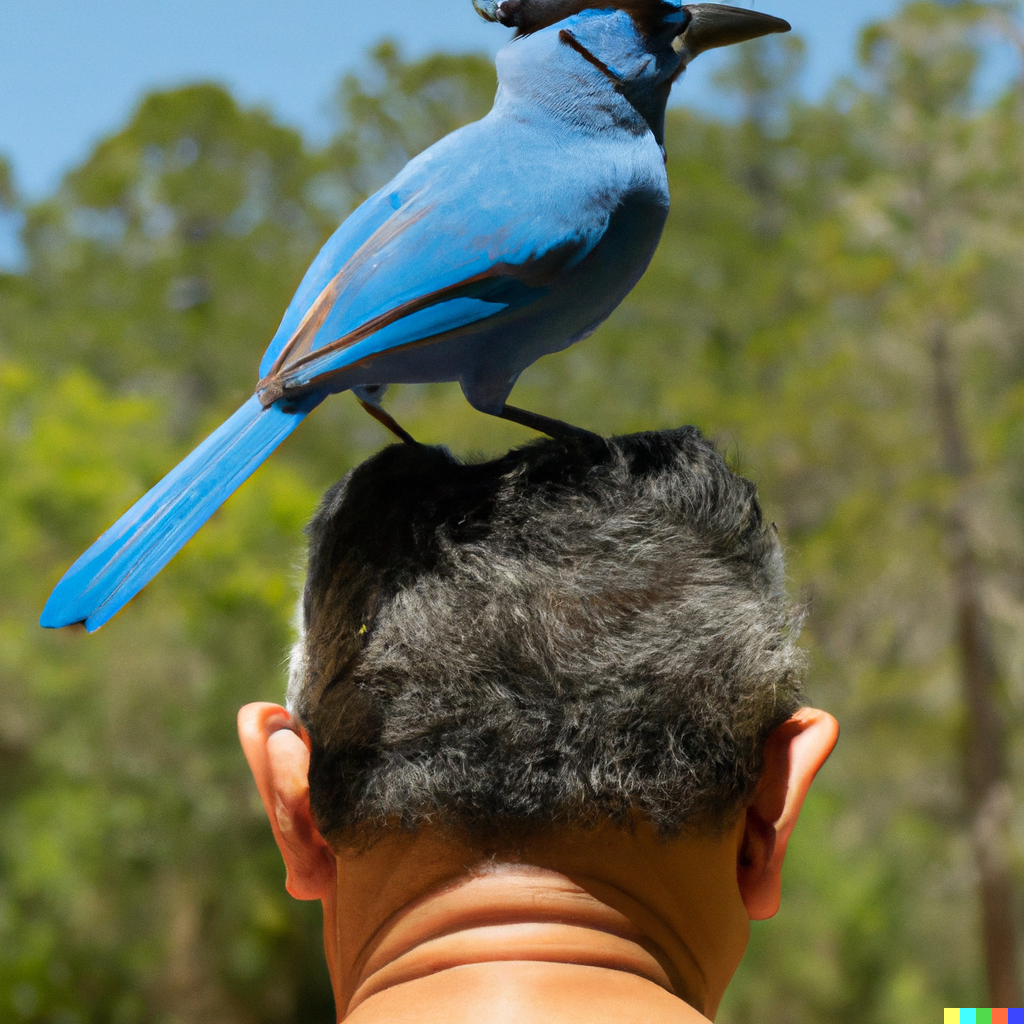

Input Text:  a blue bird standing on a person head
Output Image Descripition: a bird with a blue and green beak sitting on a person
Similarity:  0.8147503137588501


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
text_prompt = 'a blue bird standing on a person head'
image_path = 'sample.png'

print("Input Image: ")
img = cv2.imread(image_path)
cv2_imshow(img)

print("Input Text: ",text_prompt)

score_spatial_relation(text_prompt, image_path, sentence_model, image_cap_model)